## Classificação de imagens utilizando multiplos modelos de classificação


In [1]:
# Data and manipulation

import pandas as pd
import numpy as np
import tensorflow as tf

# Modeling
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.manifold import TSNE


from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, KFold


#Visualizing

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
import sys
sys.path.append('../')
from utils import plot_2d_embedding

# MNIST Problem


The MNIST database of handwritten digits, [available from this page](http://yann.lecun.com/exdb/mnist/), has a training set of 60,000 examples, and a test set of 10,000 examples. It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. 

In [5]:
(x_train_mnist, y_train_mnist), (x_test_mnist, y_test_mnist) = tf.keras.datasets.mnist.load_data()

In [6]:
#shape de treino dos datasets

print(x_train_mnist.shape)
print(y_train_mnist.shape)
print(x_test_mnist.shape)
print(y_test_mnist.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [5]:
# investigando quantos valores existem em cada classe
pd.DataFrame(y_train_mnist, columns = ['classes']).groupby('classes').size()

classes
0    5923
1    6742
2    5958
3    6131
4    5842
5    5421
6    5918
7    6265
8    5851
9    5949
dtype: int64

In [6]:
x_train_mnist[0].shape

(28, 28)

### Entendendo uma imagem: Uma Matriz! (ou tensor)

In [7]:
x_train_mnist[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
         18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
          0,   0],
       [  

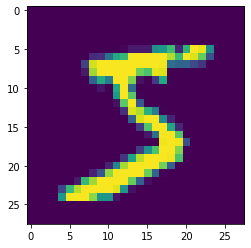

In [8]:
plt.imshow(x_train_mnist[0])

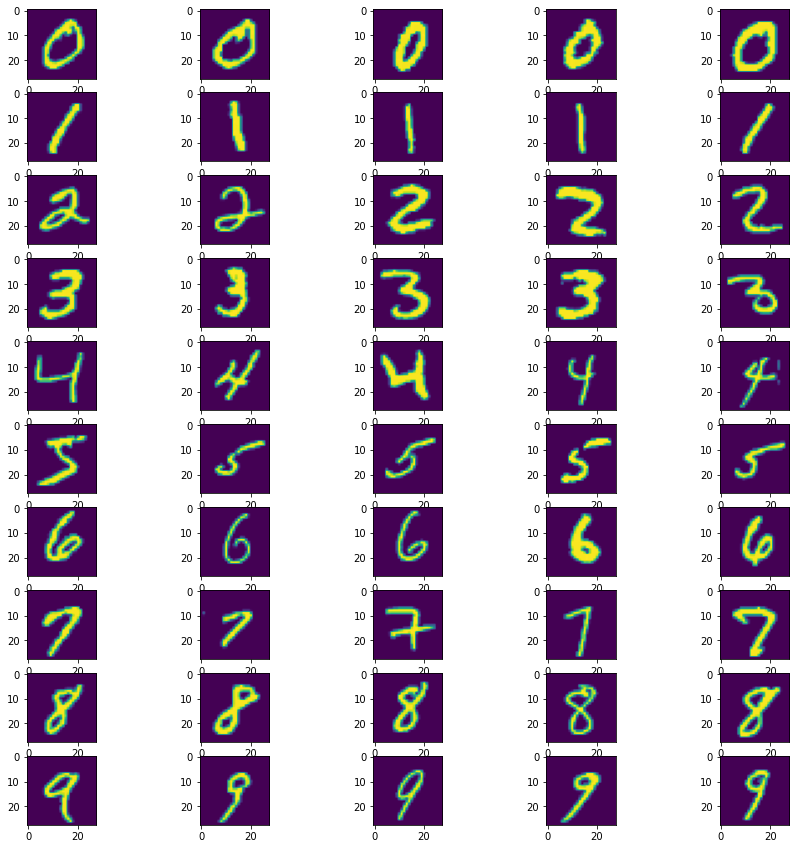

In [9]:
num_labels = 10
num_columns = 5

fig, ax = plt.subplots(num_labels, num_columns, figsize=(15,15))


for label in range(num_labels):
    for i in range(num_columns):
        images = x_train_mnist[y_train_mnist == label][0:num_columns]
        ax[label,i].imshow(images[i])

### Vetorização das matrizes (Flatten)

![flatten](../imgs/flatten.png)

## Exemplo 

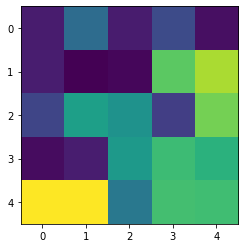

In [10]:
example = np.random.rand(5,5)
plt.imshow(example)

In [11]:
print(example)
example.shape

[[7.70069178e-02 3.49230982e-01 7.52737897e-02 2.27209589e-01
  4.17918329e-02]
 [8.09428990e-02 1.67613985e-04 1.72131356e-02 7.40817634e-01
  8.64167295e-01]
 [2.09183683e-01 5.58427826e-01 5.06487078e-01 1.83757336e-01
  7.84001050e-01]
 [3.43009248e-02 7.98223883e-02 5.37875138e-01 6.79323390e-01
  6.31840184e-01]
 [9.91851583e-01 9.91294020e-01 3.98533306e-01 6.95674567e-01
  6.87315802e-01]]


(5, 5)

In [12]:
flat = example.flatten()
print(flat)
flat.shape

[7.70069178e-02 3.49230982e-01 7.52737897e-02 2.27209589e-01
 4.17918329e-02 8.09428990e-02 1.67613985e-04 1.72131356e-02
 7.40817634e-01 8.64167295e-01 2.09183683e-01 5.58427826e-01
 5.06487078e-01 1.83757336e-01 7.84001050e-01 3.43009248e-02
 7.98223883e-02 5.37875138e-01 6.79323390e-01 6.31840184e-01
 9.91851583e-01 9.91294020e-01 3.98533306e-01 6.95674567e-01
 6.87315802e-01]


(25,)

In [13]:
reshape = example.reshape(-1,1)
print(reshape)
reshape.shape

[[7.70069178e-02]
 [3.49230982e-01]
 [7.52737897e-02]
 [2.27209589e-01]
 [4.17918329e-02]
 [8.09428990e-02]
 [1.67613985e-04]
 [1.72131356e-02]
 [7.40817634e-01]
 [8.64167295e-01]
 [2.09183683e-01]
 [5.58427826e-01]
 [5.06487078e-01]
 [1.83757336e-01]
 [7.84001050e-01]
 [3.43009248e-02]
 [7.98223883e-02]
 [5.37875138e-01]
 [6.79323390e-01]
 [6.31840184e-01]
 [9.91851583e-01]
 [9.91294020e-01]
 [3.98533306e-01]
 [6.95674567e-01]
 [6.87315802e-01]]


(25, 1)

### reshape de todas as imagens 

In [4]:
reshaped_train = x_train_mnist.reshape(60000, 28*28)
reshaped_test = x_test_mnist.reshape(10000, 28*28)

Agora, cada linha é uma imagem vetorizada. Podemos conferir, recuperando uma imagem como exemplo.

In [15]:
reshaped_train[0].reshape(28,28)

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
         18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
          0,   0],
       [  

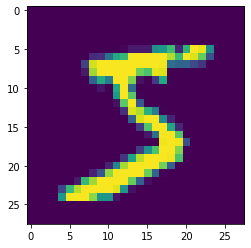

In [16]:
plt.imshow(reshaped_train[0].reshape(28,28))

### Exploração da Matriz a ser modelada

Calculando correlação entre os pixels das imagens

In [5]:
df = pd.DataFrame(reshaped_train)
corr = df.corr()

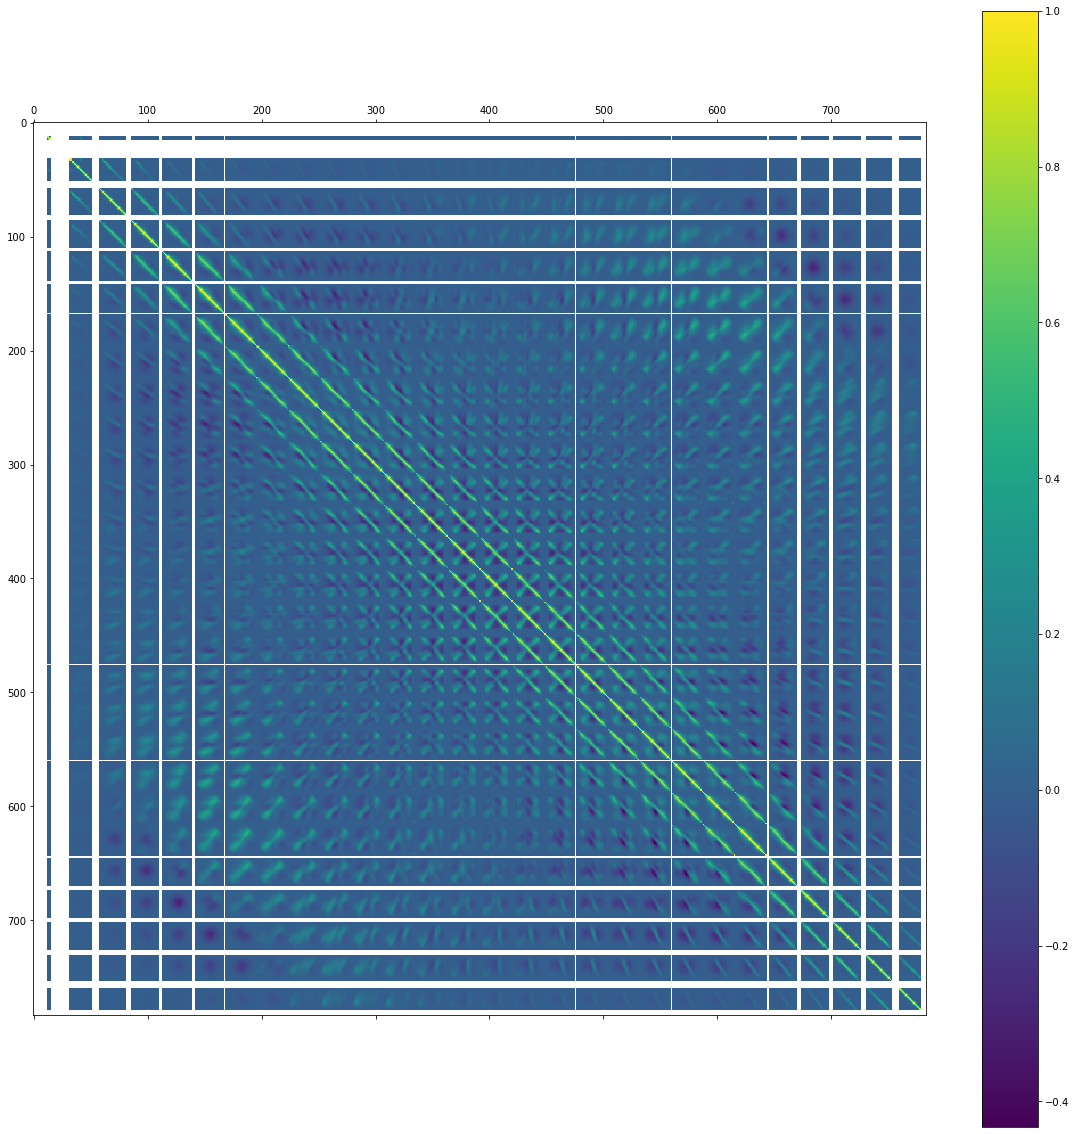

In [20]:
plt.figure(figsize=(20, 20))
plt.matshow(corr, fignum = 1)
plt.colorbar()

Importante notar: Existem colunas que são correlacionadas e também existem colunas inteiras que são constantes. Isso significa que essas colunas não agregam nenhum valor para nenhum modelo, dado que eles não variam em função dos obvserváveis.

In [6]:
# removendo columns constantes.
# df.iloc[0] -> primeiro valor de cada coluna
# df != do primeiro valor de cada coluna? por coluna
# .any() -> algum deles é diferente do primeiro valor de cada coluna?
bool_indicator = (df != df.iloc[0]).any()
df_without_constant_columns = df.loc[:, bool_indicator]

In [19]:
corr = df_without_constant_columns.corr()

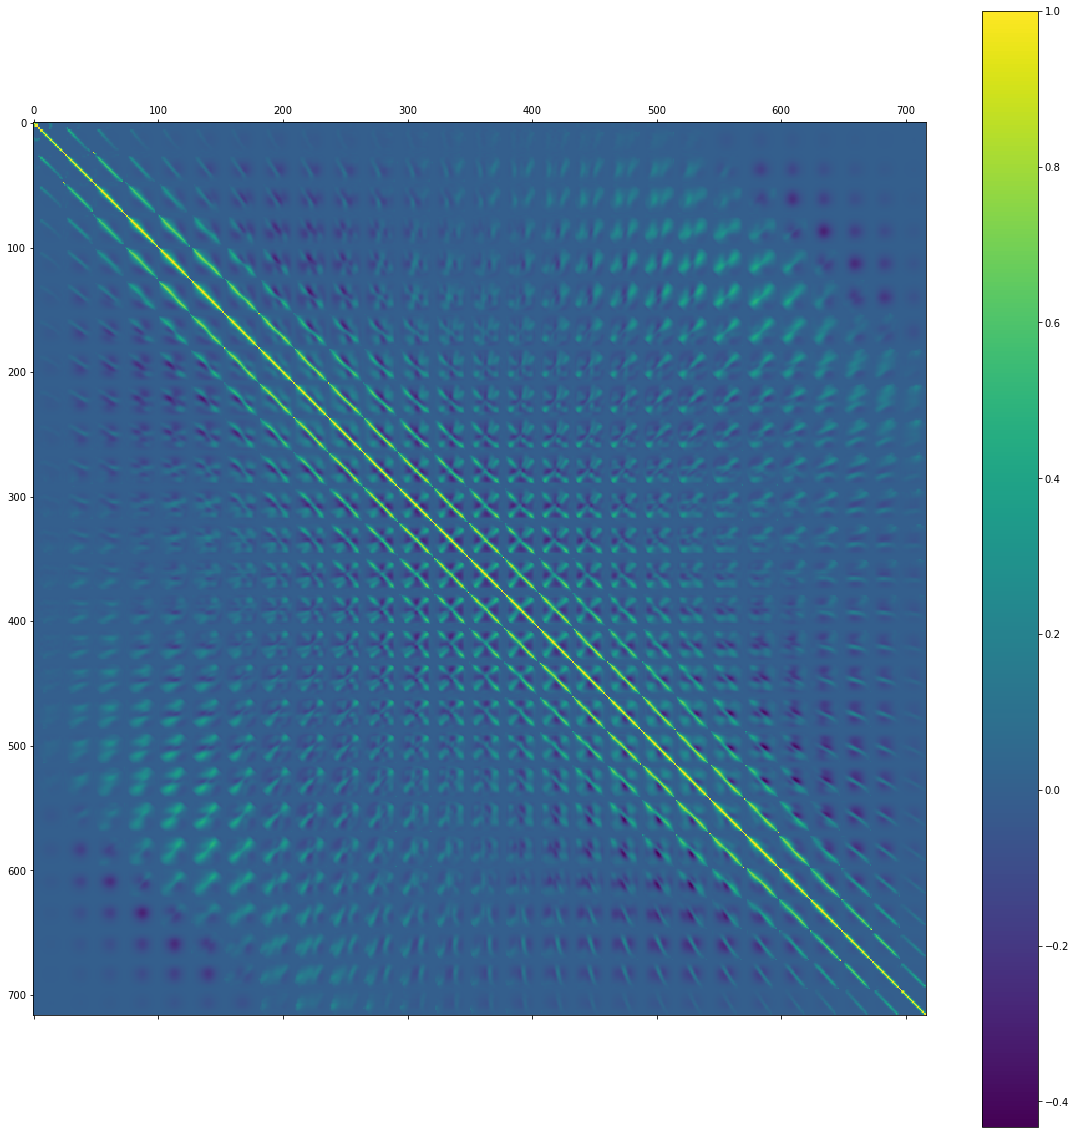

In [20]:
plt.figure(figsize=(20, 20))
plt.matshow(corr, fignum = 1)
plt.colorbar()

## PCA

In [22]:
pca = PCA()
pca.n_components = df_without_constant_columns.shape[1]
pca_data = pca.fit_transform(df_without_constant_columns)

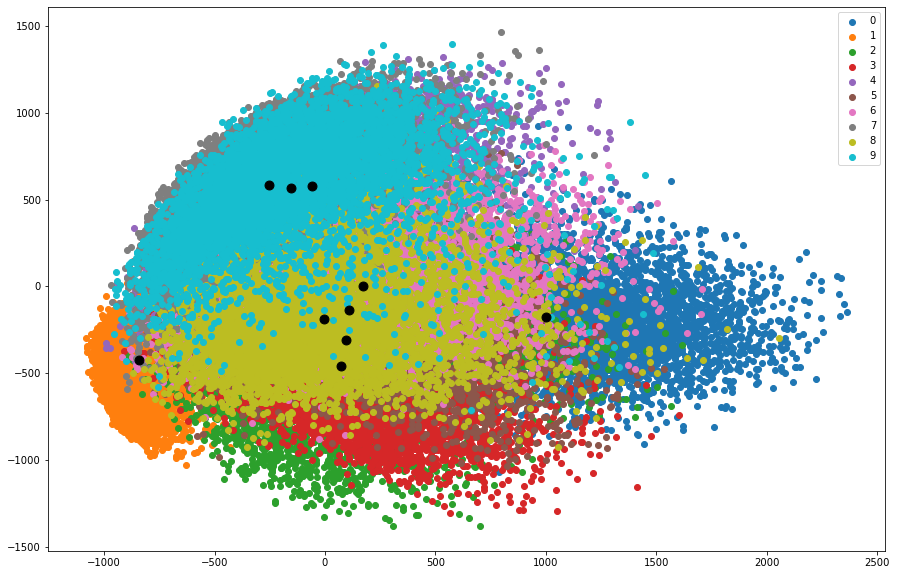

In [23]:
x = pca_data[:,0]
y = pca_data[:,1]

label = y_train_mnist
u_labels = np.unique(y_train_mnist)

plt.figure(figsize=(15, 10))

centroids_0 = []
centroids_1 = []

for i in u_labels:
    x_current = x[label == i]
    y_current = y[label == i]
    
    centroids_0.append(x_current.mean())
    centroids_1.append(y_current.mean())
    
    plt.scatter(x_current, y_current, label = i)
plt.scatter(centroids_0 , centroids_1 , s = 80, color = 'k')
plt.legend()
plt.show()

percebemos que existem segmentos, mas eles se sobresaem em duas dimensões: Não conseguimos explicar muito bem o comportamento do dado apenas com essas informações.

In [21]:
percentage_var_explained = pca.explained_variance_ / np.sum(pca.explained_variance_);
cum_var_explained = np.cumsum(percentage_var_explained)

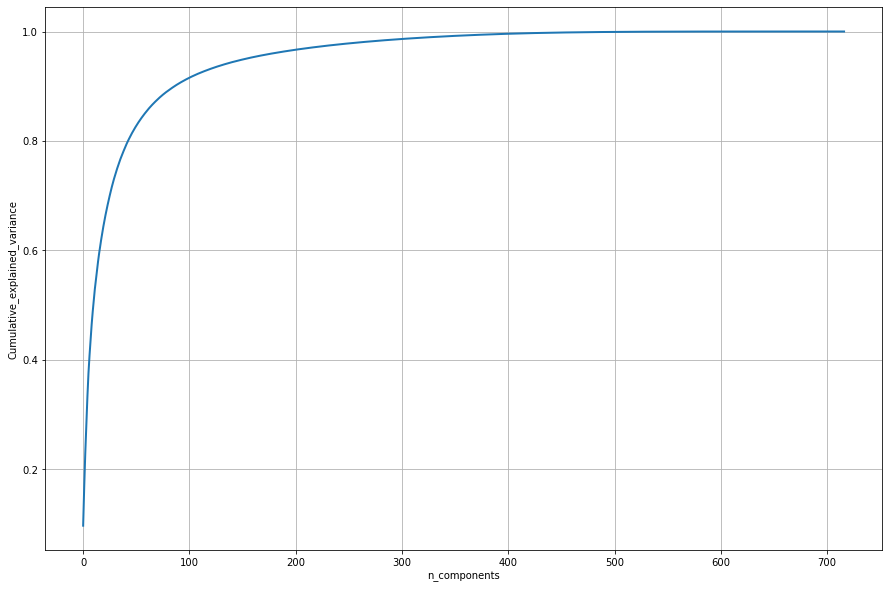

In [22]:
plt.figure(figsize=(15, 10))
plt.plot(cum_var_explained, linewidth=2)
plt.axis('tight')
plt.grid()
plt.xlabel('n_components')
plt.ylabel('Cumulative_explained_variance')
plt.show()

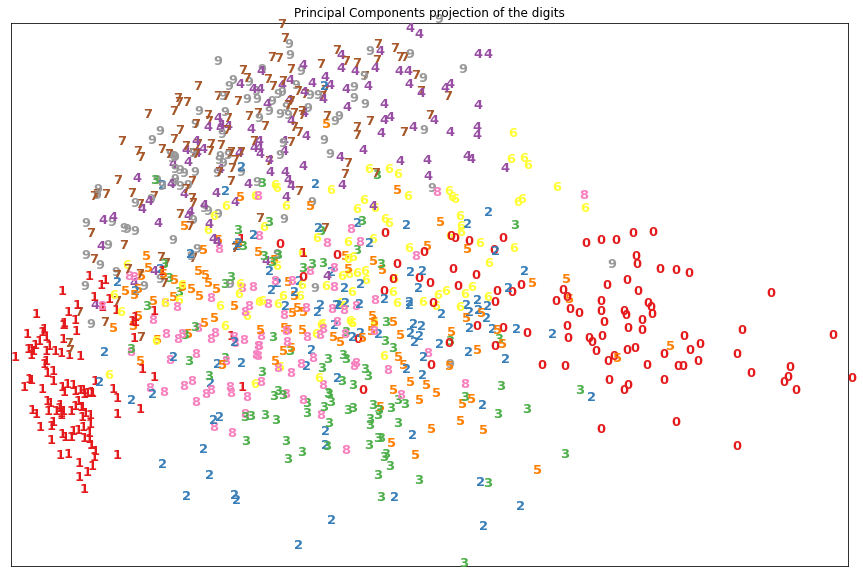

In [23]:
y = y_train_mnist[0:1000]
plot_2d_embedding(pca_data[0:1000], y = y, labels = y,size = 13, "Principal Components projection of the digits")

Com mais dimensões, temos mais da variabilidade explicada. Assim, conseguimos trazer aproximadamente 90% da variabilidade do dado para o modelo com 100 componentes.

## LDA 

In [27]:
lda = LinearDiscriminantAnalysis(n_components=2)
lda.fit(df_without_constant_columns, y_train_mnist)
lda_data = lda.transform(df_without_constant_columns)

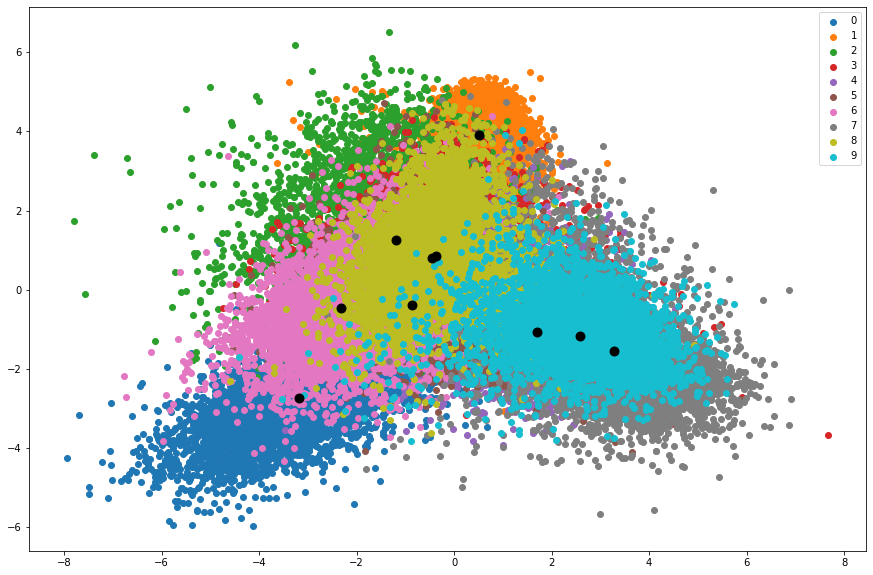

In [28]:
x = lda_data[:,0]
y = lda_data[:,1]

label = y_train_mnist
u_labels = np.unique(y_train_mnist)

plt.figure(figsize=(15, 10))

centroids_0 = []
centroids_1 = []

for i in u_labels:
    x_current = x[label == i]
    y_current = y[label == i]
    
    centroids_0.append(x_current.mean())
    centroids_1.append(y_current.mean())
    
    plt.scatter(x_current, y_current, label = i)
plt.scatter(centroids_0 , centroids_1 , s = 80, color = 'k')
plt.legend()
plt.show()

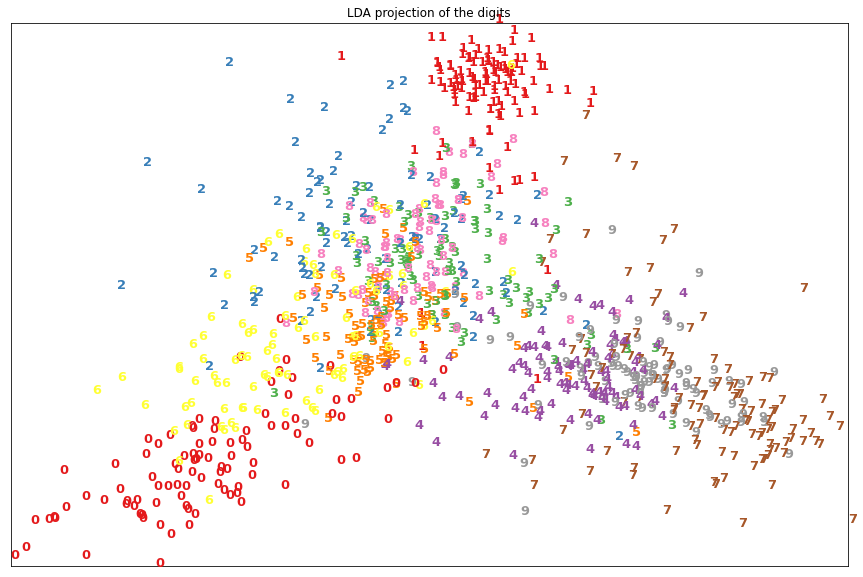

In [29]:
y = y_train_mnist[0:1000]
plot_2d_embedding(lda_data[0:1000], y = y, labels = y, size = 13, "LDA projection of the digits")

## T-SNE

In [30]:
import numpy as np
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(df_without_constant_columns[0:1000])

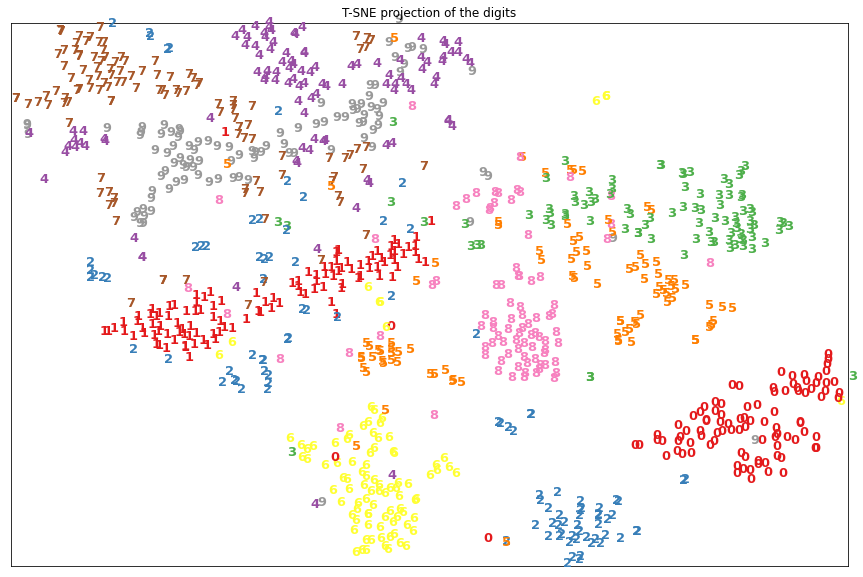

In [31]:
y = y_train_mnist[0:1000]
plot_2d_embedding(X_embedded,y = y, labels = y,size = 13, "T-SNE projection of the digits")

# Modelagem 

Vamos realizar o processamento do dado para o shape que gostaríamos, também remover as colunas que não trazem informação. Além disso, realizaremos o PCA, para reduzirmos a dimensão do problema.

In [7]:
reshaped_train = reshaped_train[:, bool_indicator]
reshaped_test = reshaped_test[:, bool_indicator]

In [27]:
# Search para melhor numero de componentes e de penalizacao para regressao logisticia

pca = PCA()

# tol = tolerancia para não demorar muito rodando (atencao para convergencia)
# multi_class = "multinomial" por ser um dataset com mais de 2 labels.
# Note que por default, a classe já identifica e trata isso, mas preferi explicitar.
# Nesse caso, o modelo utiliza a distribuição multinomial ao invés da bernoulli na modelagem

logistic = LogisticRegression(max_iter=10000, tol=0.1, multi_class="multinomial")

pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])

# parametros de diferentes steps da pipeline podem ser definidos com '__'
param_grid = {
    'pca__n_components': [2, 5, 50, 100],
    'logistic__C': np.logspace(-4, 4, 2),
}

search = GridSearchCV(pipe, param_grid, n_jobs=-1)
search.fit(reshaped_train, y_train_mnist)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.917):
{'logistic__C': 10000.0, 'pca__n_components': 100}


In [32]:
results_df = pd.DataFrame(search.cv_results_)
results_df = results_df.sort_values(by=['rank_test_score'])
results_df = (
    results_df
    .set_index(results_df["params"].apply(
        lambda x: "_".join(str(val) for val in x.values()))
    )
    .rename_axis('kernel')
)
results_df[
    ['params', 'rank_test_score', 'mean_test_score', 'std_test_score']
]

params  \
kernel                                                           
10000.0_100  {'logistic__C': 10000.0, 'pca__n_components': ...   
0.0001_100   {'logistic__C': 0.0001, 'pca__n_components': 100}   
0.0001_50     {'logistic__C': 0.0001, 'pca__n_components': 50}   
10000.0_50   {'logistic__C': 10000.0, 'pca__n_components': 50}   
0.0001_5       {'logistic__C': 0.0001, 'pca__n_components': 5}   
10000.0_5     {'logistic__C': 10000.0, 'pca__n_components': 5}   
10000.0_2     {'logistic__C': 10000.0, 'pca__n_components': 2}   
0.0001_2       {'logistic__C': 0.0001, 'pca__n_components': 2}   

             rank_test_score  mean_test_score  std_test_score  
kernel                                                         
10000.0_100                1         0.916567        0.004172  
0.0001_100                 2         0.916483        0.005201  
0.0001_50                  3         0.905383        0.005716  
10000.0_50                 4         0.905100        0.006238  
0.0001_5                   5         0.672950        0.010200  
10000.0_5                  6         0.672667        0.010518  
10000.0_2                  7         0.442950        0.006731  
0.0001_2                   8         0.442733        0.006349

In [31]:
y_pred = search.predict(reshaped_test)
target_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
print(classification_report(y_test_mnist, y_pred, target_names=target_names))

              precision    recall  f1-score   support

           0       0.95      0.98      0.96       980
           1       0.97      0.98      0.97      1135
           2       0.92      0.90      0.91      1032
           3       0.90      0.91      0.90      1010
           4       0.93      0.92      0.93       982
           5       0.89      0.87      0.88       892
           6       0.94      0.95      0.94       958
           7       0.93      0.92      0.93      1028
           8       0.88      0.88      0.88       974
           9       0.90      0.90      0.90      1009

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)

Como sabemos que o PCA com 100 componentes traz um valor razoável para o modelo, vamos definir ele como nosso padrão na modelagem

In [8]:
pca = PCA(n_components=100).fit(reshaped_train)
embedded_data_train = pca.transform(reshaped_train)
embedded_data_test = pca.transform(reshaped_test)

### Comparando diferentes modelos: Logistica, QDA, SVM e random forest.

Vamos treinar apenas com 5 mil observações para estimar a performance e depois vamos reajustar o modelo com todos os dados

In [12]:
logistic = LogisticRegression(max_iter=10000, tol=0.1, multi_class="multinomial")
logistic.fit(embedded_data_train[0:5000], y_train_mnist[0:5000])

y_pred = logistic.predict(embedded_data_test)
target_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
print(classification_report(y_test_mnist, y_pred, target_names=target_names))

              precision    recall  f1-score   support

           0       0.89      0.92      0.91       980
           1       0.92      0.96      0.94      1135
           2       0.86      0.83      0.84      1032
           3       0.85      0.85      0.85      1010
           4       0.88      0.89      0.89       982
           5       0.83      0.81      0.82       892
           6       0.88      0.89      0.88       958
           7       0.86      0.88      0.87      1028
           8       0.82      0.80      0.81       974
           9       0.85      0.84      0.85      1009

    accuracy                           0.87     10000
   macro avg       0.86      0.87      0.86     10000
weighted avg       0.87      0.87      0.87     10000



/Users/dimassoares/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [9]:
cv = KFold(n_splits=10, random_state=1, shuffle = True)

In [11]:
svc = SVC()

param_grid = {'kernel': ['rbf', 'linear'], 
              'gamma': [1e-3, 1e-4],
              'C': [1, 10, 100, 1000]}

search = GridSearchCV(svc, param_grid, n_jobs=-1, cv = cv, verbose = 3)
search_svc = search.fit(embedded_data_train[0:5000], y_train_mnist[0:5000])
print("Best parameter (CV score=%0.3f):" % search_svc.best_score_)
print(search_svc.best_params_)

y_pred = search_svc.predict(embedded_data_test)
target_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
print(classification_report(y_test_mnist, y_pred, target_names=target_names))

Fitting 10 folds for each of 16 candidates, totalling 160 fits
Best parameter (CV score=0.904):
{'C': 1, 'gamma': 0.001, 'kernel': 'linear'}
              precision    recall  f1-score   support

           0       0.93      0.98      0.95       980
           1       0.96      0.98      0.97      1135
           2       0.88      0.90      0.89      1032
           3       0.83      0.90      0.86      1010
           4       0.87      0.93      0.90       982
           5       0.87      0.82      0.84       892
           6       0.94      0.92      0.93       958
           7       0.90      0.88      0.89      1028
           8       0.91      0.81      0.86       974
           9       0.89      0.82      0.85      1009

    accuracy                           0.90     10000
   macro avg       0.90      0.89      0.89     10000
weighted avg       0.90      0.90      0.90     10000



In [29]:
qda = QuadraticDiscriminantAnalysis()

param_grid = {'priors': [np.array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]), 
                         np.array([0.73, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03]), 
                         np.array([0.03, 0.73, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03]), 
                         np.array([0.03, 0.03, 0.73, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03]), 
                         np.array([0.03, 0.03, 0.03, 0.73, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03]), 
                         np.array([0.03, 0.03, 0.03, 0.03, 0.73, 0.03, 0.03, 0.03, 0.03, 0.03]), 
                         np.array([0.03, 0.03, 0.03, 0.03, 0.03, 0.73, 0.03, 0.03, 0.03, 0.03]), 
                         np.array([0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.73, 0.03, 0.03, 0.03]), 
                         np.array([0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.73, 0.03, 0.03]), 
                         np.array([0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.73, 0.03]), 
                         np.array([0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.73])]}

search = GridSearchCV(qda, 
                      param_grid,
                      scoring='accuracy',
                      n_jobs=-1, 
                      cv = cv, 
                      verbose = 3)

search_qda = search.fit(embedded_data_train[0:5000], y_train_mnist[0:5000])
print("Best parameter (CV score=%0.3f):" % search_qda.best_score_)
print(search_qda.best_params_)

y_pred = search_qda.predict(embedded_data_test)
target_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
print(classification_report(y_test_mnist, y_pred, target_names=target_names))

Fitting 10 folds for each of 11 candidates, totalling 110 fits
Best parameter (CV score=0.946):
{'priors': array([0.03, 0.03, 0.03, 0.73, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03])}
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       980
           1       1.00      0.92      0.95      1135
           2       0.90      0.97      0.94      1032
           3       0.91      0.95      0.93      1010
           4       0.94      0.97      0.95       982
           5       0.95      0.93      0.94       892
           6       0.99      0.93      0.96       958
           7       0.98      0.91      0.94      1028
           8       0.82      0.94      0.88       974
           9       0.96      0.90      0.93      1009

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



In [30]:
rfc = RandomForestClassifier()

param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

search = GridSearchCV(rfc, param_grid, n_jobs=-1, cv = cv, verbose = 3)
search_rfc = search.fit(embedded_data_train[0:5000], y_train_mnist[0:5000])
print("Best parameter (CV score=%0.3f):" % search_rfc.best_score_)
print(search_rfc.best_params_)

y_pred = search_rfc.predict(embedded_data_test)
target_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
print(classification_report(y_test_mnist, y_pred, target_names=target_names))

Fitting 10 folds for each of 60 candidates, totalling 600 fits
Best parameter (CV score=0.899):
{'criterion': 'entropy', 'max_depth': 8, 'max_features': 'log2', 'n_estimators': 500}
              precision    recall  f1-score   support

           0       0.92      0.95      0.93       980
           1       0.94      0.98      0.96      1135
           2       0.90      0.86      0.88      1032
           3       0.87      0.90      0.88      1010
           4       0.83      0.90      0.87       982
           5       0.93      0.79      0.85       892
           6       0.89      0.93      0.91       958
           7       0.90      0.89      0.89      1028
           8       0.86      0.84      0.85       974
           9       0.87      0.84      0.85      1009

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



# Fashion problem

Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. The github project is [available here](https://github.com/zalandoresearch/fashion-mnist).

In [3]:
(x_train_fashion, y_train_fashion), (x_test_fashion, y_test_fashion) = tf.keras.datasets.fashion_mnist.load_data()

In [4]:
print(x_train_fashion.shape)
print(y_train_fashion.shape)

(60000, 28, 28)
(60000,)


In [9]:
x_train_fashion[0].shape

(28, 28)

In [10]:
x_train_fashion[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,
          0,   0,  13,  73,   0,   0,   1,   4,   0,   0,   0,   0,   1,
          1,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
          0,  36, 136, 127,  62,  54,   0,   0,   0,   1,   3,   4,   0,
          0,   3],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   6,
          0, 102, 204, 176, 134, 144, 123,  23,   0,   0,   0,   0,  12,
         10,   0],
       [  

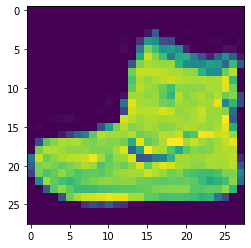

In [11]:
plt.imshow(x_train_fashion[0])

In [25]:
# investigando quantos valores existem em cada classe
pd.DataFrame(y_train_fashion, columns = ['classes']).groupby('classes').size()

classes
0    6000
1    6000
2    6000
3    6000
4    6000
5    6000
6    6000
7    6000
8    6000
9    6000
dtype: int64

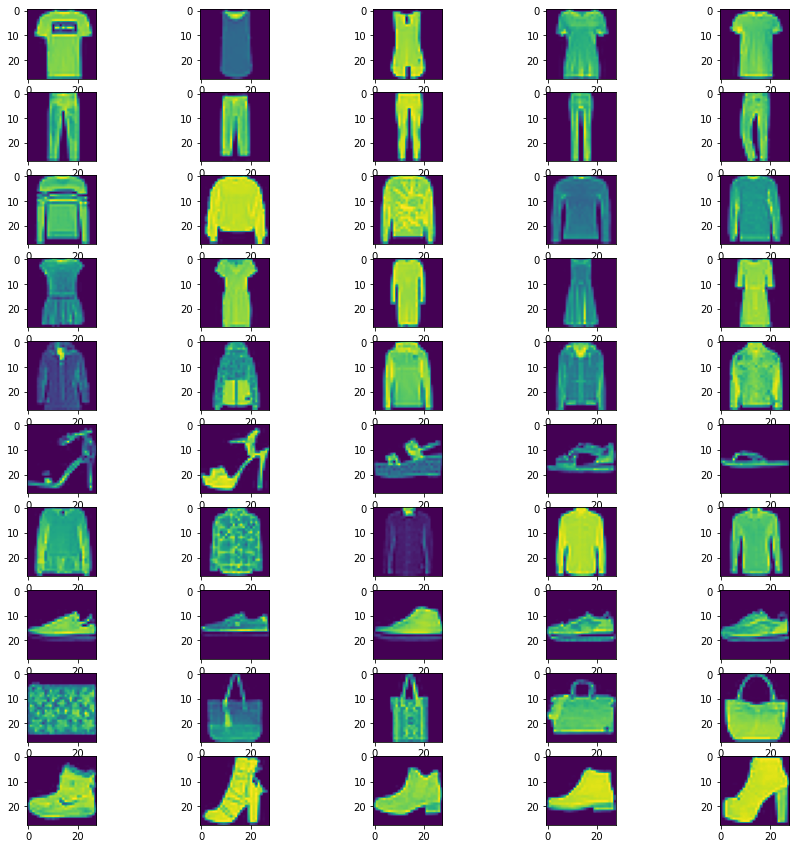

In [26]:
num_labels = 10
num_columns = 5

fig, ax = plt.subplots(num_labels, num_columns, figsize=(15,15))


for label in range(num_labels):
    for i in range(num_columns):
        images = x_train_fashion[y_train_fashion == label][0:num_columns]
        ax[label,i].imshow(images[i])

In [5]:
reshaped_train = x_train_fashion.reshape(60000, 28*28)
reshaped_test = x_test_fashion.reshape(10000, 28*28)

In [8]:
df = pd.DataFrame(reshaped_train)
corr = df.corr()

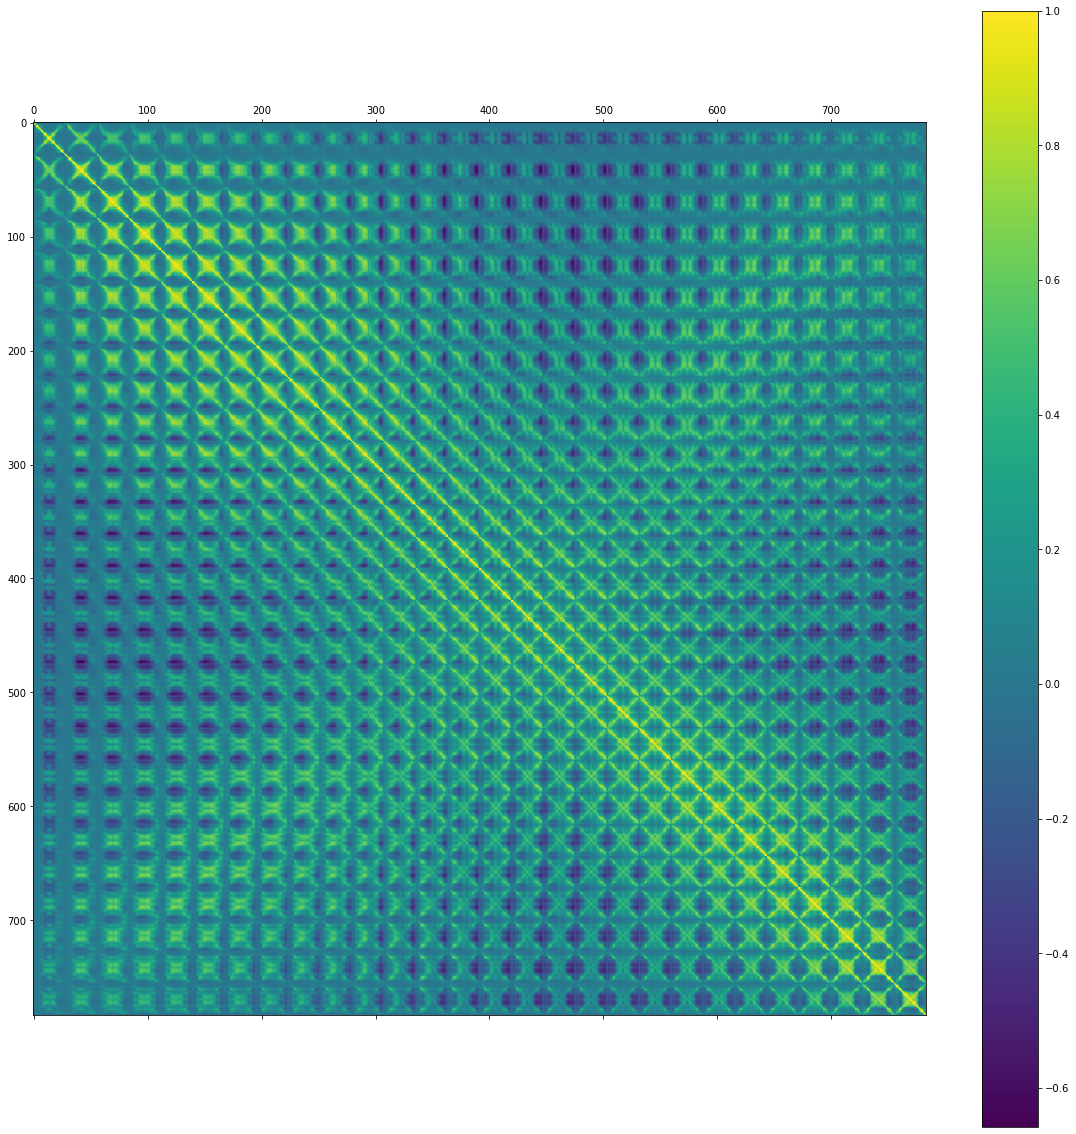

In [9]:
plt.figure(figsize=(20, 20))
plt.matshow(corr, fignum = 1)
plt.colorbar()

## PCA

In [10]:
label_to_plot = []
for label in y_train_fashion:
    if label == 0:
        label_to_plot.append("T-shirt")
    elif label == 1:
        label_to_plot.append("Trouser")
    elif label == 2:
        label_to_plot.append("Pullover")
    elif label == 3:
        label_to_plot.append("Dress")
    elif label == 4:
        label_to_plot.append("Coat")
    elif label == 5:
        label_to_plot.append("Sandal")
    elif label == 6:
        label_to_plot.append("Shirt")
    elif label == 7:
        label_to_plot.append("Sneaker")
    elif label == 8:
        label_to_plot.append("Bag")
    else:
        label_to_plot.append("Ankle boot")

In [11]:
pca = PCA()
pca.n_components = df.shape[1]
pca_data = pca.fit_transform(df)

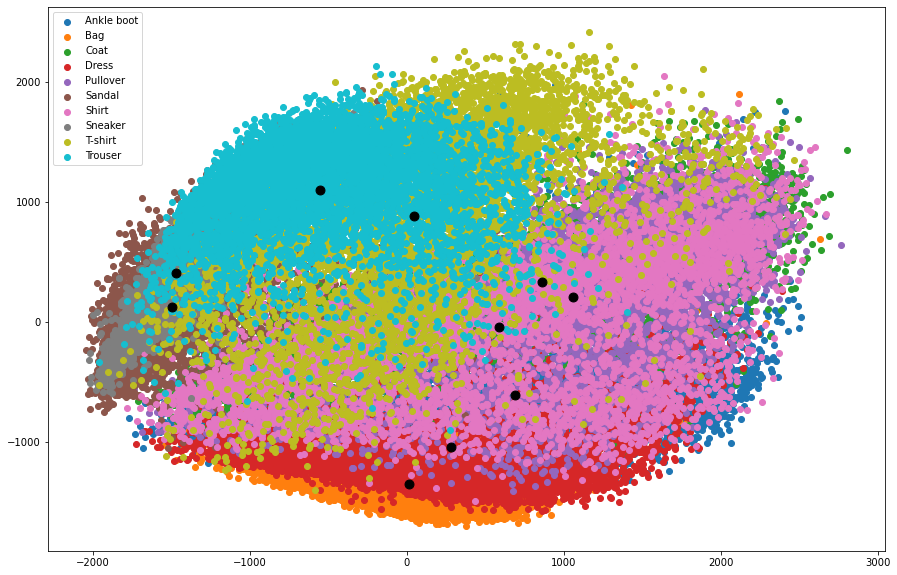

In [36]:
x = pca_data[:,0]
y = pca_data[:,1]

label = y_train_fashion
u_labels = np.unique(y_train_fashion)

plt.figure(figsize=(15, 10))

centroids_0 = []
centroids_1 = []

for i in u_labels:
    x_current = x[label == i]
    y_current = y[label == i]
    
    centroids_0.append(x_current.mean())
    centroids_1.append(y_current.mean())
    
    plt.scatter(x_current, y_current, label = np.unique(label_to_plot)[i])
plt.scatter(centroids_0 , centroids_1 , s = 80, color = 'k')

plt.legend()
plt.show()

percebemos que existem segmentos, mas eles se sobresaem em duas dimensões: Não conseguimos explicar muito bem o comportamento do dado apenas com essas informações.

In [19]:
percentage_var_explained = pca.explained_variance_ / np.sum(pca.explained_variance_);
cum_var_explained = np.cumsum(percentage_var_explained)

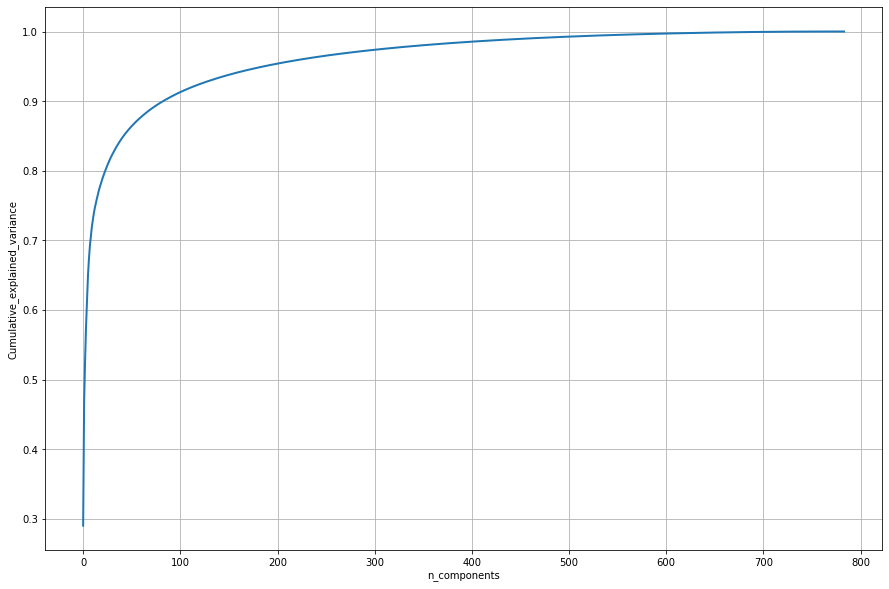

In [20]:
plt.figure(figsize=(15, 10))
plt.plot(cum_var_explained, linewidth=2)
plt.axis('tight')
plt.grid()
plt.xlabel('n_components')
plt.ylabel('Cumulative_explained_variance')
plt.show()

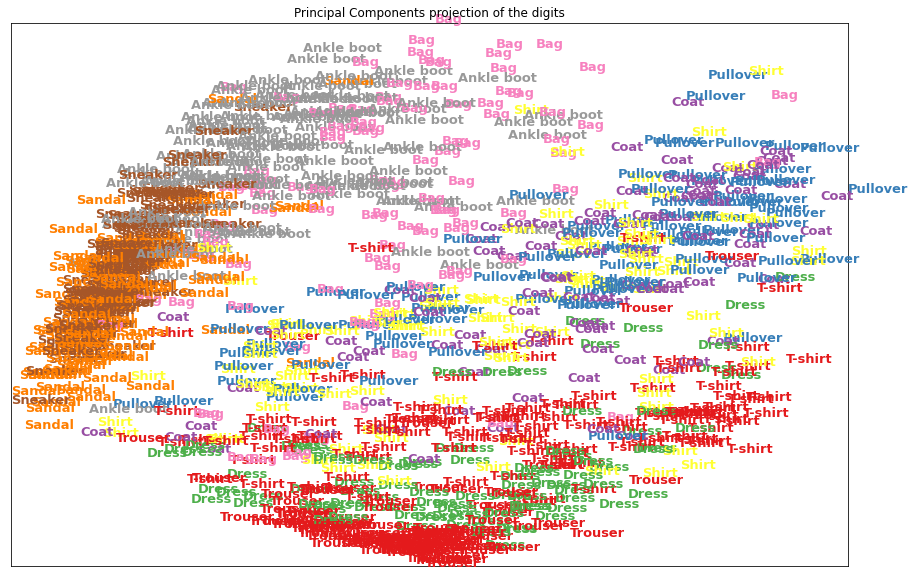

In [13]:
y = y_train_fashion[0:1000]
plot_2d_embedding(pca_data[0:1000], y = y, labels = label_to_plot[0:1000], size = 13, title = "Principal Components projection of the Fashion")

Com mais dimensões, temos mais da variabilidade explicada. Assim, conseguimos trazer aproximadamente 90% da variabilidade do dado para o modelo com 100 componentes.

## LDA 

In [14]:
lda = LinearDiscriminantAnalysis(n_components=2)
lda.fit(df, y_train_fashion)
lda_data = lda.transform(df)

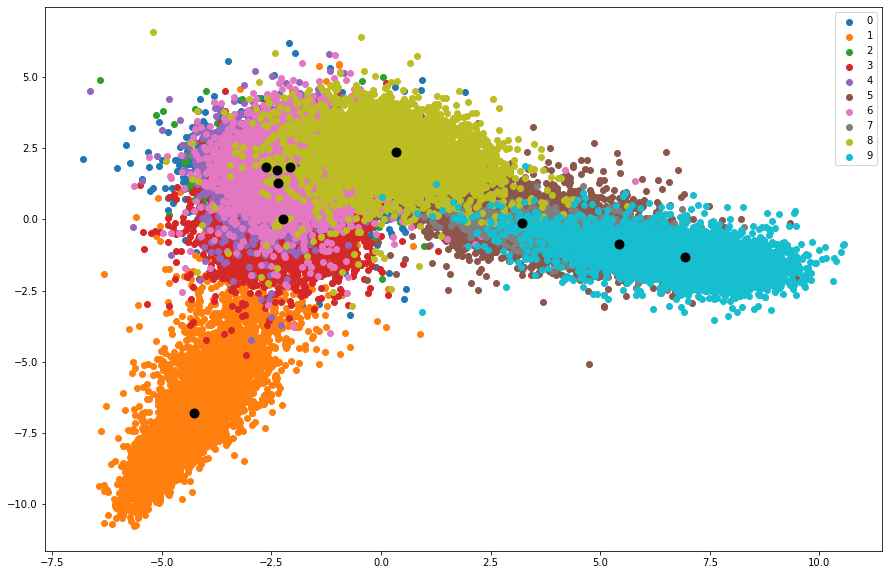

In [26]:
x = lda_data[:,0]
y = lda_data[:,1]

label = y_train_fashion
u_labels = np.unique(y_train_fashion)

plt.figure(figsize=(15, 10))

centroids_0 = []
centroids_1 = []

for i in u_labels:
    x_current = x[label == i]
    y_current = y[label == i]
    
    centroids_0.append(x_current.mean())
    centroids_1.append(y_current.mean())
    
    plt.scatter(x_current, y_current, label = i)
plt.scatter(centroids_0 , centroids_1 , s = 80, color = 'k')
plt.legend()
plt.show()

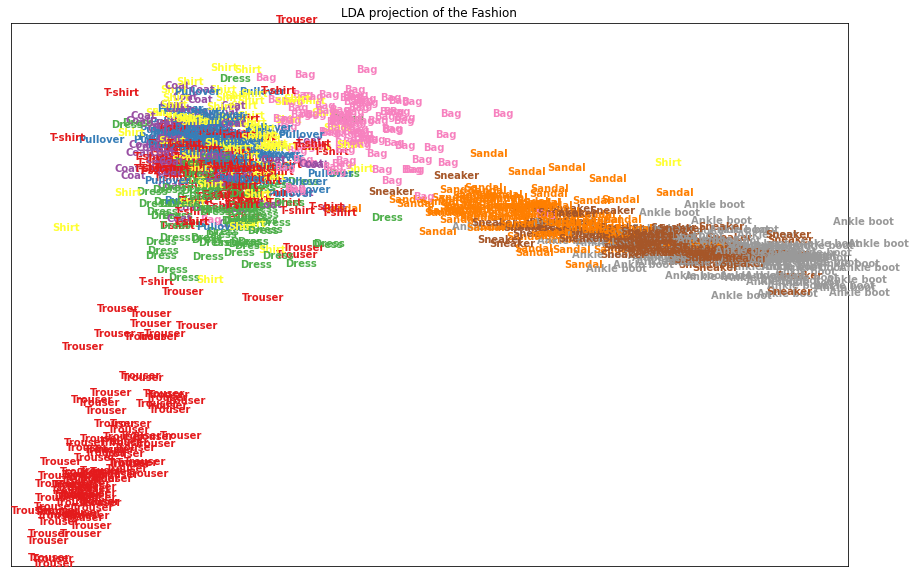

In [18]:
y = y_train_fashion[0:1000]
plot_2d_embedding(lda_data[0:1000], y = y, labels = label_to_plot, size = 10, title = "LDA projection of the Fashion")

## T-SNE

In [22]:
X_embedded = TSNE(n_components=2).fit_transform(df[0:500])

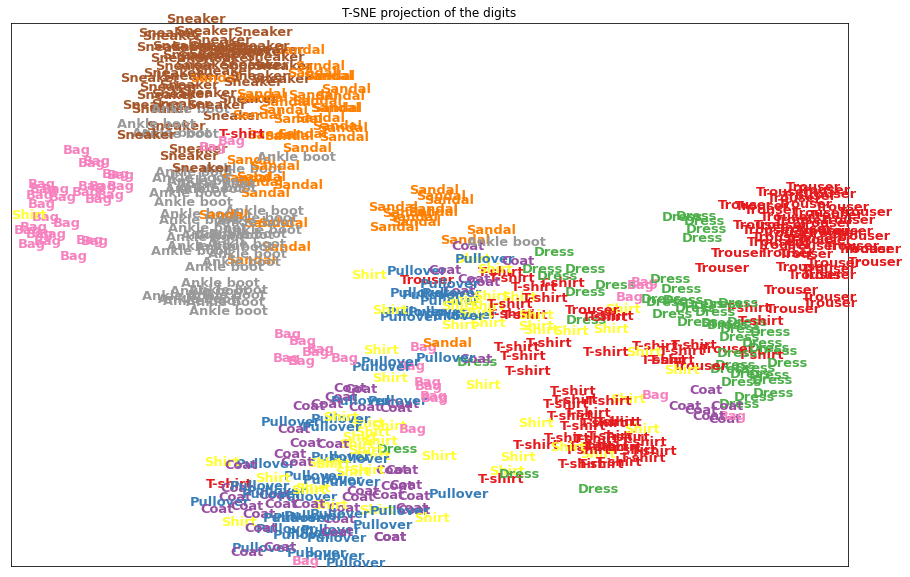

In [23]:
y = y_train_fashion[0:500]
plot_2d_embedding(X_embedded, y, label_to_plot, size = 13, title =  "T-SNE projection of the Fashion")

# Modelagem 

In [26]:
# Search para melhor numero de componentes e de penalizacao para regressao logisticia

pca = PCA()

# tol = tolerancia para não demorar muito rodando (atencao para convergencia)
# multi_class = "multinomial" por ser um dataset com mais de 2 labels.
# Note que por default, a classe já identifica e trata isso, mas preferi explicitar.
# Nesse caso, o modelo utiliza a distribuição multinomial ao invés da bernoulli na modelagem

logistic = LogisticRegression(max_iter=10000, tol=0.1, multi_class="multinomial")

pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])

# parametros de diferentes steps da pipeline podem ser definidos com '__'
param_grid = {
    'pca__n_components': [2, 5, 50, 100],
    'logistic__C': np.logspace(-4, 4, 2),
}

search = GridSearchCV(pipe, param_grid, n_jobs=-1)
search.fit(reshaped_train, y_train_fashion)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

KeyboardInterrupt: 

In [ ]:
results_df = pd.DataFrame(search.cv_results_)
results_df = results_df.sort_values(by=['rank_test_score'])
results_df = (
    results_df
    .set_index(results_df["params"].apply(
        lambda x: "_".join(str(val) for val in x.values()))
    )
    .rename_axis('kernel')
)
results_df[
    ['params', 'rank_test_score', 'mean_test_score', 'std_test_score']
]

In [ ]:
y_pred = search.predict(reshaped_test)
target_names = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
print(classification_report(y_test_fashion, y_pred, target_names=target_names))

Como sabemos que o PCA com 100 componentes traz um valor razoável para o modelo, vamos definir ele como nosso padrão na modelagem

In [ ]:
pca = PCA(n_components=100).fit(reshaped_train)
embedded_data_train = pca.transform(reshaped_train)
embedded_data_test = pca.transform(reshaped_test)

### Comparando diferentes modelos: Logistica, QDA, SVM e random forest.

Vamos treinar apenas com 5 mil observações para estimar a performance e depois vamos reajustar o modelo com todos os dados

In [ ]:
logistic = LogisticRegression(max_iter=10000, tol=0.1, multi_class="multinomial")
logistic.fit(embedded_data_train[0:5000], y_train_fashion[0:5000])

y_pred = logistic.predict(embedded_data_test)

print(classification_report(y_train_fashion, y_pred, target_names=target_names))

In [ ]:
cv = KFold(n_splits=10, random_state=1, shuffle = True)

In [ ]:
svc = SVC()

param_grid = {'kernel': ['rbf', 'linear'], 
              'gamma': [1e-3, 1e-4],
              'C': [1, 10, 100, 1000]}

search = GridSearchCV(svc, param_grid, n_jobs=-1, cv = cv, verbose = 3)
search_svc = search.fit(embedded_data_train[0:5000], y_train_fashion[0:5000])
print("Best parameter (CV score=%0.3f):" % search_svc.best_score_)
print(search_svc.best_params_)

y_pred = search_svc.predict(embedded_data_test)

print(classification_report(y_train_fashion, y_pred, target_names=target_names))

In [ ]:
qda = QuadraticDiscriminantAnalysis()

param_grid = {'priors': [np.array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]), 
                         np.array([0.73, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03]), 
                         np.array([0.03, 0.73, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03]), 
                         np.array([0.03, 0.03, 0.73, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03]), 
                         np.array([0.03, 0.03, 0.03, 0.73, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03]), 
                         np.array([0.03, 0.03, 0.03, 0.03, 0.73, 0.03, 0.03, 0.03, 0.03, 0.03]), 
                         np.array([0.03, 0.03, 0.03, 0.03, 0.03, 0.73, 0.03, 0.03, 0.03, 0.03]), 
                         np.array([0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.73, 0.03, 0.03, 0.03]), 
                         np.array([0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.73, 0.03, 0.03]), 
                         np.array([0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.73, 0.03]), 
                         np.array([0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.73])]}

search = GridSearchCV(qda, 
                      param_grid,
                      scoring='accuracy',
                      n_jobs=-1, 
                      cv = cv, 
                      verbose = 3)

search_qda = search.fit(embedded_data_train[0:5000], y_train_fashion[0:5000])
print("Best parameter (CV score=%0.3f):" % search_qda.best_score_)
print(search_qda.best_params_)

y_pred = search_qda.predict(embedded_data_test)

print(classification_report(y_train_fashion, y_pred, target_names=target_names))

In [ ]:
rfc = RandomForestClassifier()

param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

search = GridSearchCV(rfc, param_grid, n_jobs=-1, cv = cv, verbose = 3)
search_rfc = search.fit(embedded_data_train[0:5000], y_train_fashion[0:5000])
print("Best parameter (CV score=%0.3f):" % search_rfc.best_score_)
print(search_rfc.best_params_)

y_pred = search_rfc.predict(embedded_data_test)

print(classification_report(y_train_fashion, y_pred, target_names=target_names))